This scenario builds upon the previous one, with the major change being to the MEV rewards. Rather than having a fixed reward as in the previous scenario,

In [5]:
import numpy as np
import random

num_entities = 100
num_validators = 50000
num_slots = 30000
fixed_reward = 0.025
split_threshold = 32

# Create validator_entity_mapping and initialize rewards
validator_entity_mapping = [i % num_entities for i in range(num_validators)]
validator_rewards = np.zeros(num_validators)
entity_rewards = np.zeros(num_entities)

# Create lists of validators per entity
validators_per_entity = [[] for _ in range(num_entities)]
for validator_idx, entity in enumerate(validator_entity_mapping):
    validators_per_entity[entity].append(validator_idx)

# create distribution
num_points = 210_000
max_values = [692, 550, 198]
desired_median = 0.065 # This is the "average" median in scenario 3

# Generate a lognormal distribution with a long tail
dist = np.random.lognormal(mean=np.log(desired_median), sigma=1.5, size=num_points)

# Truncate the distribution between 0 and 0.13 ETH
truncated_dist = dist[(dist >= 0) & (dist <= 0.13)]

# Calculate the number of data points we need to add to the upper part
num_points_to_add = num_points - len(truncated_dist)

# Add the remaining data points with specific maximum values
additional_points = []
for max_value in max_values:
    points = np.linspace(0.13, max_value, num_points_to_add // len(max_values))
    additional_points.extend(points)

# Combine the truncated lower part and the additional upper part
dist = np.concatenate([truncated_dist, additional_points])

# Run the simulation
for i in range(num_slots):
    # Select a random validator
    if i%100 == 0:
        print(i)
    chosen_validator = random.randrange(num_validators)

    # Assign rewards
    block_reward = fixed_reward
    mev_reward = np.random.choice(dist)
    #print(mev_reward)
    total_reward = block_reward + mev_reward

    validator_rewards[chosen_validator] += total_reward
    entity_rewards[validator_entity_mapping[chosen_validator]] += total_reward

    # Check if we need to spawn a new validator for any entity
    for entity_idx in range(num_entities):
        if entity_rewards[entity_idx] >= split_threshold:
            # Spawn a new validator for this entity
            num_validators += 1
            validator_entity_mapping.append(entity_idx)
            validator_rewards = np.append(validator_rewards, 0)
            validators_per_entity[entity_idx].append(num_validators - 1)

            # Deduct the rewards used to spawn the new validator from the existing validators
            to_deduct = split_threshold
            for validator_idx in validators_per_entity[entity_idx]:
                if to_deduct > 0:
                    deduct_amount = min(validator_rewards[validator_idx], to_deduct)
                    validator_rewards[validator_idx] -= deduct_amount
                    entity_rewards[entity_idx] -= deduct_amount
                    to_deduct -= deduct_amount

# Print the top and bottom 20 validator stakes
sorted_indices = np.argsort(validator_rewards)
print("Top 20 validator stakes:")
for idx in sorted_indices[-20:]:
    print(f"Validator {idx}: {validator_rewards[idx]}")

print("Bottom 20 validator stakes:")
for idx in sorted_indices[:20]:
    print(f"Validator {idx}: {validator_rewards[idx]}")

# Count validators per entity
validators_count_per_entity = [len(validators) for validators in validators_per_entity]

# Calculate the total value each entity controls
entity_values = np.array(validators_count_per_entity) * 32 + entity_rewards

# Print the results
print("Validators per entity:")
for i in range(num_entities):
    print(f"Entity {i}: {validators_count_per_entity[i]}")

print("Total value each entity controls:")
for i in range(num_entities):
    print(f"Entity {i}: {entity_values[i]}")




0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18


Summary Statistics:
Number of validators: 121802
Average stake: 0.017643926944734784
Median stake: 0.0
Standard deviation of stake: 1.492791705631465

Top 20 validator stakes:
  Validator     Stake
-----------  --------
     114353  497.578
     104538   29.9606
      73780   29.0548
     109867   28.8119
     101889   28.6884
      66111   27.7069
      94210   26.5121
      34185   26.1668
     105000   25.8834
      19229   24.5745
      64678   24.048
      84732   23.7363
      87873   23.3687
      56919   22.9023
      58686   22.3395
      79425   21.6105
     108477   21.4298
      61811   21.1392
      52757   19.7217
     110111   19.7163

Bottom 20 validator stakes:
  Validator    Stake
-----------  -------
          0        0
      80905        0
      80904        0
      80903        0
      80902        0
      80901        0
      80900        0
      80899        0
      80898        0
      80897        0
      80896        0
      80895        0
      80894       

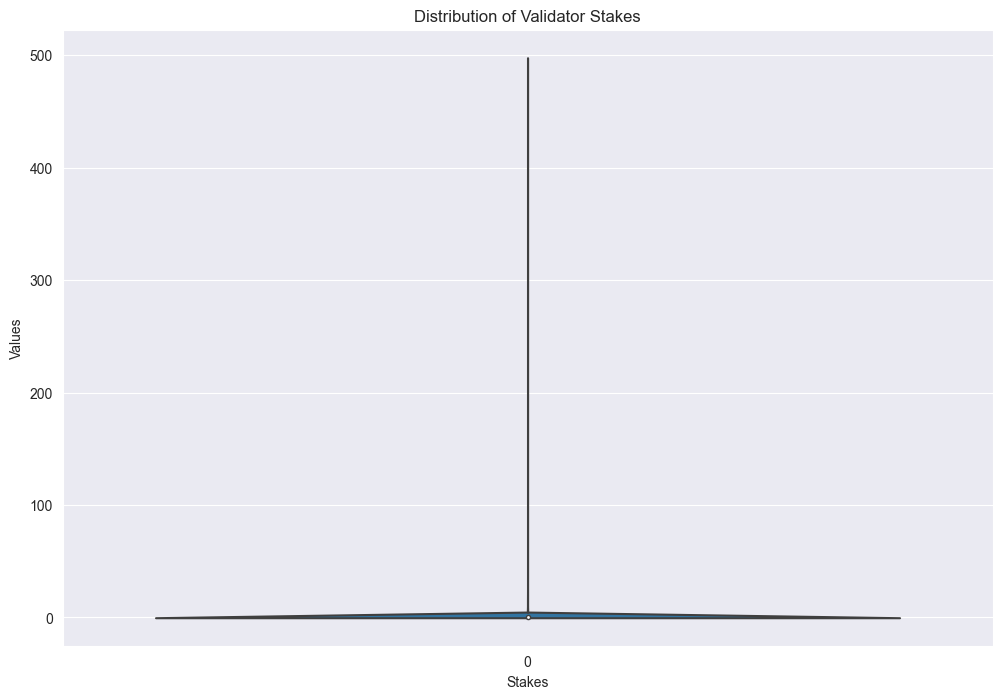

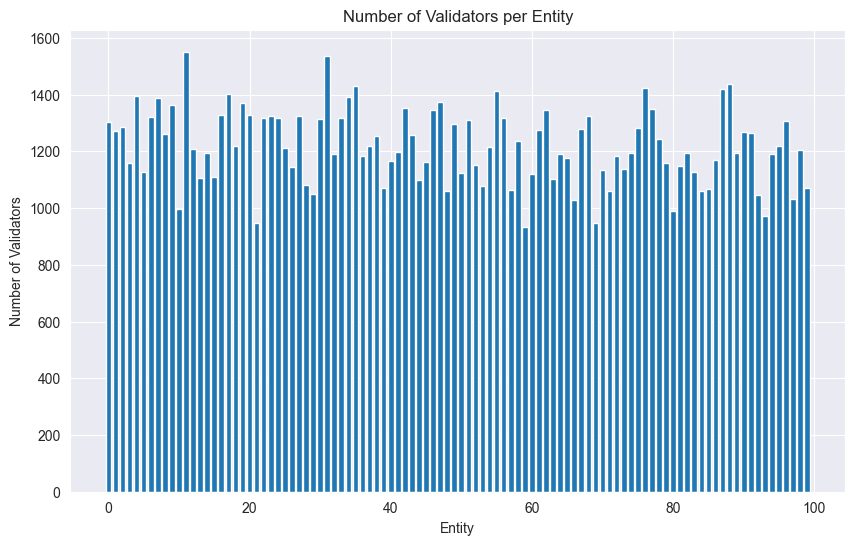

In [8]:
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np

# Calculate summary statistics
num_validators = len(validator_rewards)
average_stake = np.mean(validator_rewards)
median_stake = np.median(validator_rewards)
std_dev_stake = np.std(validator_rewards)

summary_statistics = {
    "Number of validators": num_validators,
    "Average stake": average_stake,
    "Median stake": median_stake,
    "Standard deviation of stake": std_dev_stake,
}

# Print the summary statistics
print("\nSummary Statistics:")
for k, v in summary_statistics.items():
    print(f"{k}: {v}")

# Print the top and bottom 20 validator stakes
sorted_indices = np.argsort(validator_rewards)
top_stakes = [(idx, validator_rewards[idx]) for idx in sorted_indices[-20:]][::-1]
bottom_stakes = [(idx, validator_rewards[idx]) for idx in sorted_indices[:20]]

print("\nTop 20 validator stakes:")
print(tabulate(top_stakes, headers=["Validator", "Stake"]))

print("\nBottom 20 validator stakes:")
print(tabulate(bottom_stakes, headers=["Validator", "Stake"]))

# Calculate entity statistics
validators_count_per_entity = [len(validators) for validators in validators_per_entity]
entity_values = np.array(validators_count_per_entity) * 32 + entity_rewards

entity_statistics = list(zip(range(num_entities), validators_count_per_entity, entity_values))

# Print the entity statistics
print("\nEntity Statistics:")
print(tabulate(entity_statistics, headers=["Entity", "Validators", "Total Value"]))

import seaborn as sns

plt.figure(figsize=(12, 8))
sns.violinplot(validator_rewards)
plt.title('Distribution of Validator Stakes')
plt.xlabel('Stakes')
plt.ylabel('Values')
plt.show()

# Plot the number of validators per entity
plt.figure(figsize=(10, 6))
plt.bar(range(num_entities), validators_count_per_entity)
plt.title('Number of Validators per Entity')
plt.xlabel('Entity')
plt.ylabel('Number of Validators')
plt.show()

In [7]:
# Calculate the number of validators per entity
validators_count_per_entity = [len(validators) for validators in validators_per_entity]

# Calculate the stats
min_val = np.min(validators_count_per_entity)
max_val = np.max(validators_count_per_entity)
median_val = np.median(validators_count_per_entity)
avg_val = np.mean(validators_count_per_entity)

# Print the stats
print("Number of validators per entity:")
print(f"Minimum: {min_val}")
print(f"Maximum: {max_val}")
print(f"Median: {median_val}")
print(f"Average: {avg_val}")

Number of validators per entity:
Minimum: 933
Maximum: 1551
Median: 1209.5
Average: 1218.02
